In [1]:
import os
# os.chdir("/Users/davidamat/Documents/Projects/deepsetstats")
os.chdir("/Users/davidamat/Documents/Personal/deepsetstats")
from importlib import reload

In [2]:
from deepsetstats.utils import utils_tools
from deepsetstats.utils import constants as c
from deepsetstats.utils import videocapture as vc

In [600]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import copy
import torch
import time

In [601]:
utils_tools = reload(utils_tools)
c = reload(c)
vc = reload(vc)

In [5]:
# Dictionary of vids
extension = ".mp4"
gs = [
    "wb",
    "rg",
    "ao",
    "us"
]
# c.PATH_VIDS = "/Users/davidamat/Documents/BackUp/DeepSetStats"
c.PATH_VIDS = "/Users/davidamat/Documents/BackUp/DeepSetStats"
d_path_vids = {vid: str(Path(c.PATH_VIDS) / (vid + extension)) for vid in gs }

In [6]:
import numpy
numpy.set_printoptions(threshold=2000)

# 1. Explore frames

In [7]:
VC = vc.VideoClass(d_path_vids["wb"])
vc_wb = vc.VideoClass(d_path_vids["wb"])
vc_ao = vc.VideoClass(d_path_vids["ao"])
vc_us = vc.VideoClass(d_path_vids["us"])
vc_rg = vc.VideoClass(d_path_vids["rg"])

In [8]:
d_vc = {
    "wb": vc_wb,
    "rg": vc_rg,
    "ao": vc_ao,
    "us": vc_us
}

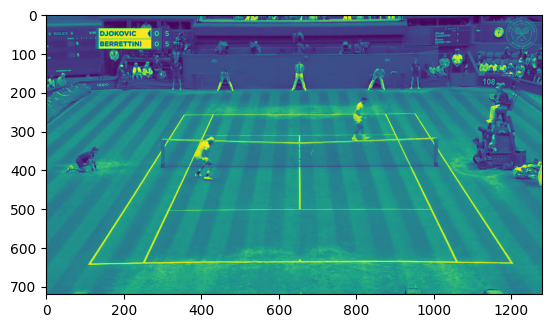

In [9]:
# Wimbledon
f_wb = vc_wb.get_frame(29*25)
fg_wb = VC._correct_color(f_wb, gray=True)
VC.show_frame(fg_wb)

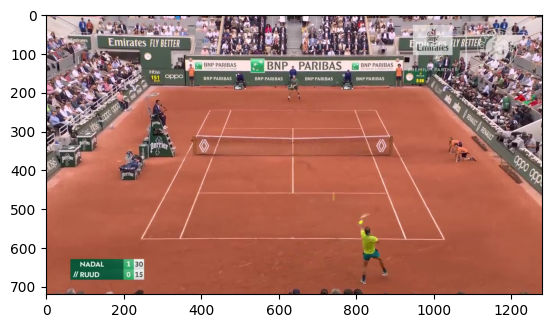

In [10]:
# RG
f_rg = vc_rg.get_frame(29*25)
fg_rg = vc_rg._correct_color(f_rg, gray=True)
VC.show_frame(f_rg)

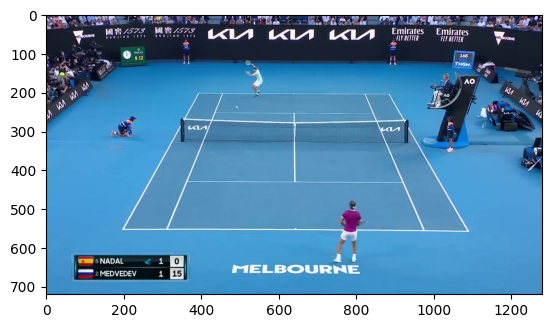

In [11]:
# RG
f_ao = vc_ao.get_frame(29*25)
fg_ao = vc_ao._correct_color(f_ao, gray=True)
VC.show_frame(f_ao)

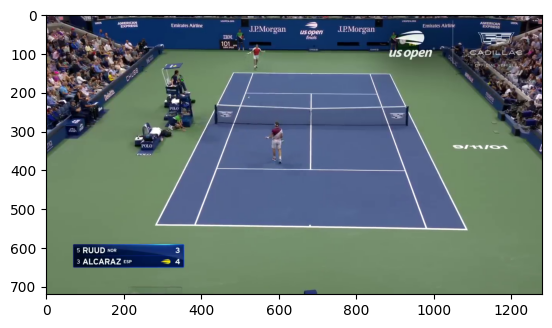

In [12]:
# US
f_us = vc_us.get_frame(25*25)
fg_us = vc_us._correct_color(f_us, gray=True)
VC.show_frame(f_us)

In [13]:
d_f = {
    "ao": f_ao,
    "us": f_us,
    "rg": f_rg,
    "wb": f_wb
}

d_fg = {
    "ao": fg_ao,
    "us": fg_us,
    "rg": fg_rg,
    "wb": fg_wb
}

## 1.1 Merging frames

In [19]:
second = 160
f1 = VC.get_frame_second(second)
f2 = VC.get_frame_second(second + 0.2)
f3 = VC.get_frame_second(second + 0.4)
f4 = VC.get_frame_second(second + 0.6)

In [20]:
fm = np.mean([f1,f2,f3,f4], axis=0, dtype=int)

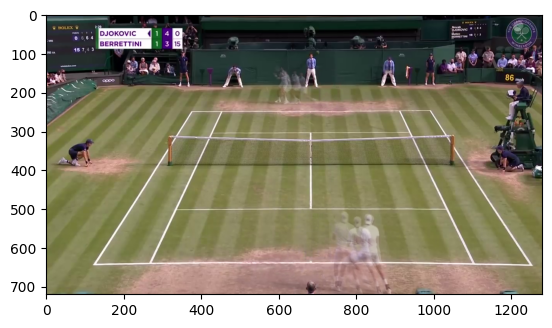

In [21]:
VC.show_frame(fm)

# 2. Court Detection

## 2.1 Court Type

In [14]:
%%time
# Court type
rgb_court, court_type = vc_rg.detect_court(d_f["rg"])
print(f"Court Type: {court_type}")
print(f"Court RGB Colors: {c.D_GRAD_LINES[court_type]}")

Court Type: CLAY
Court RGB Colors: {'COURT': array([183, 115,  84]), 'LINE_CLEAN': array([234, 177, 153]), 'LINE_DIRTY': array([189, 130, 107])}
CPU times: user 3.7 ms, sys: 2.82 ms, total: 6.52 ms
Wall time: 4.83 ms


In [807]:
# ------------------------------------- #
#     White filtering
# ------------------------------------- #
img = d_f["rg"].copy()
imgg = d_fg["rg"].copy()
mask_lines = VC.get_line_mask(img, court_type)

In [24]:
# ------------------------------------- #
#     MaxPooling
# ------------------------------------- #
maxpool = torch.nn.MaxPool2d(kernel_size=20, padding=0)

t_img_r = torch.from_numpy(-img[:,:,0]).float()
t_img_g = torch.from_numpy(-img[:,:,1]).float()
t_img_b = torch.from_numpy(-img[:,:,2]).float()
t_img_r = torch.unsqueeze(t_img_r, dim=0)
t_img_g = torch.unsqueeze(t_img_g, dim=0)
t_img_b = torch.unsqueeze(t_img_b, dim=0)

t_img_r_pool = maxpool(t_img_r)
t_img_g_pool = maxpool(t_img_g)
t_img_b_pool = maxpool(t_img_b)
t_img_pool = torch.cat
VC.show_gray(-t_imgg_pool.numpy())

In [1036]:
#slices = 8
#width_sliced = width // slices
#height_sliced = height // slices
#slice_factor = (slices-1)/slices
#width_slice_end = int(slice_factor * width)
#height_slice_end = int(slice_factor * height)
#
## ------------------------------------- #
#
## ------------------------------------- #
##     White filtering
## ------------------------------------- #
#
## ------------------------------------- #
#d_neg = {}
#do_slicing = False
#for granslam in gs:
#    fg_sliced = d_fg[granslam].copy()
#    
#    # Slice
#    if do_slicing:
#        fg_sliced = fg_sliced[height_sliced:, width_sliced:width_slice_end].copy()
#    
#    # Apply negative mask
#    fg_sliced[fg_sliced < 200] = 0
#    d_neg[granslam] = fg_sliced

## 2.2 Line detection

In [602]:
def is_court_color(color, court_type):
    rgb_abs_diff = np.abs(color - c.D_GRAD_LINES[court_type]["COURT"])
    sorted_rgb_abs_diff = np.partition(rgb_abs_diff, 2).squeeze()
    v1 = sorted_rgb_abs_diff[0] < c.TOL_RGB_MIN_DIFF
    v2 = sorted_rgb_abs_diff[1] < c.TOL_RGB_MAX_DIFF
    if v1 and v2:
        return True
    else:
        return False

In [603]:
def is_near_color(color, reference, tol_ch1 = 30, tol_ch2 = 60, tol_ch3 = 120):
    rgb_abs_diff = np.abs(color - reference)
    sorted_rgb_abs_diff = np.partition(rgb_abs_diff, 2).squeeze()
    v1 = sorted_rgb_abs_diff[0] < tol_ch1
    v2 = sorted_rgb_abs_diff[1] < tol_ch2
    v3 = sorted_rgb_abs_diff[2] < tol_ch3
    if (v1 and v2 and v3):
        return True
    else:
        return False

In [860]:
def mask_tolerance(arr, tol=(15,15,15), greater_than_tol=True, abs_val=False):
    if abs_val:
        arr = np.abs(arr)
    if greater_than_tol:
        return np.transpose(np.vstack((
            np.array(arr[:,0] > tol[0], dtype=np.int8),
            np.array(arr[:,1] > tol[1], dtype=np.int8),
            np.array(arr[:,2] > tol[2], dtype=np.int8),)))
    else:
        return np.transpose(np.vstack((
            np.array(arr[:,0] < tol[0], dtype=np.int8),
            np.array(arr[:,1] < tol[1], dtype=np.int8),
            np.array(arr[:,2] < tol[2], dtype=np.int8),)))

In [1145]:
def vslice_is_line(v_slice, court_type):
    
    # Get the median color of the slice
    vsq = np.squeeze(v_slice)
    vmedian = np.median(vsq, axis=0)
    vmedian = vmedian[None, :]
    
    # Median color should fit the court color
    is_median_court = is_court_color(vmedian, court_type)
    if not is_median_court:
        return False, -1
    
    # Vertical and Horizontal Lags
    pixel_diff = 1
    rep = np.repeat(vmedian, pixel_diff, axis=0)
    vshift_up_1 = np.vstack((vsq[pixel_diff:, :], rep))
    vshift_down_1 = np.vstack((rep, vsq[:-pixel_diff, :]))
    
    # Gradient
    dx_vsq = vshift_up_1 - vsq
    mask_grads = mask_tolerance(dx_vsq, (15,15,15), abs_val=True)  # np.array(np.abs(dx_vsq) > c.GRAD_TOL, dtype=np.int8)

    # Collapse all channels into a 1D binary gradient array, considering 
    # a 1 only if >=2 channels have a gradient color difference above threshold
    mask_grad_lighter = mask_tolerance(dx_vsq, (30,30,30))
    mask_grad_darker = mask_tolerance(dx_vsq, (-30,-30,-30), greater_than_tol=False)
    bin_grad_light = np.array(np.sum(mask_grad_lighter, axis=1) > 1, dtype=np.int8)
    bin_grad_dark = np.array(np.sum(mask_grad_darker, axis=1) > 1, dtype=np.int8)

    if sum(bin_grad_light) and sum(bin_grad_dark):
        idx_turn_light = np.min(np.where(bin_grad_light)[0])
        idx_turn_dark = np.max(np.where(bin_grad_dark)[0])
        if idx_turn_dark < idx_turn_light:
            return False, -2
    
    
    bin_grad = np.array(np.sum(mask_grads, axis=1) > 1, dtype=np.int8)
    if np.sum(bin_grad) < 1:
        return False, -3

    # Convert numbers in between
    idx_1s = np.where(bin_grad)[0]
    min_1_idx, max_1_idx = np.min(idx_1s), np.max(idx_1s)
    diff_min_max_1s = max_1_idx - min_1_idx
    is_line_width = diff_min_max_1s < c.GRAD_LINE_MAX_WIDTH
    
    # Check that the middle index of the line mask corresponds to a white
    if min_1_idx < max_1_idx:
        arr_sequence_ones = v_slice[min_1_idx:max_1_idx+1, 0, :]
        if arr_sequence_ones.shape[0] <= 1:
            arg_max_rgb = 0
        else:
            arg_max_rgb = np.argmax(np.linalg.norm(arr_sequence_ones, axis=1))
        max_rgb_idx = list(range(min_1_idx, max_1_idx + 1))[arg_max_rgb]
    else:
        max_rgb_idx = max_1_idx
    is_white_clean = is_near_color(c.D_GRAD_LINES[court_type]["LINE_CLEAN"], v_slice[max_rgb_idx])
    is_white_dirty = is_near_color(c.D_GRAD_LINES[court_type]["LINE_DIRTY"], v_slice[max_rgb_idx], tol_ch1 = 15, tol_ch2 = 25)
    is_white = is_white_clean or is_white_dirty
    if not is_white:
        return False, -4
    
    # Check that starting and ending colors are the court ones
    is_valid_slice_color = True
    if (bin_grad[0] == 0) and (bin_grad[-1] == 0):
        is_first_pixel_white_clean = is_near_color(c.D_GRAD_LINES[court_type]["LINE_CLEAN"], v_slice[0])
        is_first_pixel_white_dirty = is_near_color(c.D_GRAD_LINES[court_type]["LINE_DIRTY"], v_slice[0])
        is_last_pixel_white_clean = is_near_color(c.D_GRAD_LINES[court_type]["LINE_CLEAN"], v_slice[-1])
        is_last_pixel_white_dirty = is_near_color(c.D_GRAD_LINES[court_type]["LINE_DIRTY"], v_slice[-1])

        is_first_pixel_court_color = is_court_color(v_slice[0], court_type)
        is_last_pixel_court_color = is_court_color(v_slice[-1], court_type)
        is_first_any_white = (is_first_pixel_white_clean or is_first_pixel_white_dirty)
        is_last_any_white = (is_last_pixel_white_clean or is_last_pixel_white_dirty)
        is_edge_pixels_any_white = (is_first_any_white and ~is_last_any_white) or (~is_first_any_white and is_last_any_white)
        is_slice_court_color = is_first_pixel_court_color and is_last_pixel_court_color
        is_valid_slice_color = is_edge_pixels_any_white or is_slice_court_color

    # Tell if it is a line or not
    if is_median_court and is_line_width and is_white and is_valid_slice_color:
        return True, max_rgb_idx
    else:
        return False, -5

In [1129]:
#yy1 = ly1 + idx_middle_line - 5
#yy2 = ly1 + idx_middle_line + 5
#VC.show_frame(frame[yy1:yy2,lx1-2:lx1+2,:])

In [1130]:
def chebyshev_nodes(a, b, n):
    x_cheby = []
    for k in range(n):
        t1 = .5*(a+b)
        cos_arg = (2*k -1)*np.pi / (2*n)
        t2 = .5*(b-a)*np.cos(cos_arg)   
        x_cheby.append(t1 + t2)
    return np.array(np.sort(x_cheby), dtype=np.int16)

In [930]:
w = VC.w
h = VC.h

# OPTION 1: Equispaced Nodes
x_slices = 25
y_slices = 25
marg_x = w // 20
marg_y = h // 20
x_vlines = np.linspace(marg_x, w - marg_x, x_slices, dtype=np.int16)
y_hlines = np.linspace(marg_y, h - marg_y, y_slices, dtype=np.int16)
y_diff = np.diff(y_hlines)[0]

# OPTION 2: Chebyshev Nodes
#x_vlines = chebyshev_nodes(marg_x, w - marg_x, 25)
#y_hlines = chebyshev_nodes(marg_y, h-marg_y, 25)

d_vlines = {}
d_hlines = {}

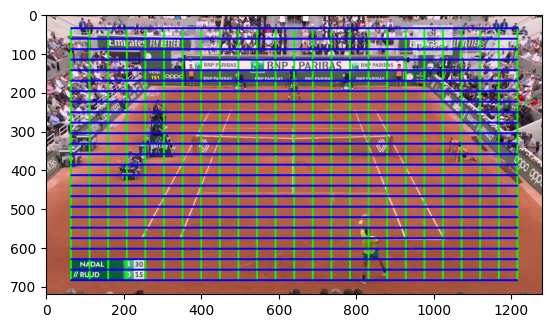

In [1146]:
# Visualize strategy
frame = d_f["rg"].copy()
for xx in x_vlines:
    cv2.line(frame, (xx, min(y_hlines)), (xx, max(y_hlines)), (0, 255, 0), 3)
for yy in y_hlines:
    cv2.line(frame, (min(x_vlines), yy), (max(x_vlines), yy), (0, 0, 255), 3)
VC.show_frame(frame)

------

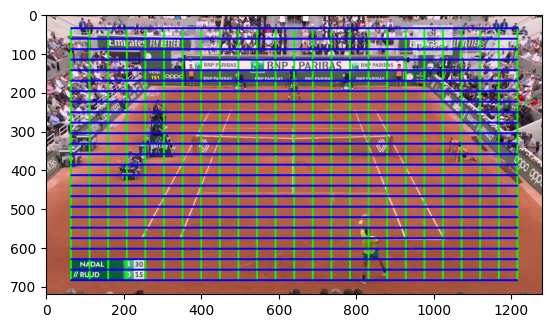

In [1147]:
gs = "rg"
# Visualize strategy
frame = d_f[gs].copy()
frame_vis = frame.copy()
for xx in x_vlines:
    cv2.line(frame_vis, (xx, min(y_hlines)), (xx, max(y_hlines)), (0, 255, 0), 3)
for yy in y_hlines:
    cv2.line(frame_vis, (min(x_vlines), yy), (max(x_vlines), yy), (0, 0, 255), 3)
VC.show_frame(frame_vis)

In [1148]:
frame = d_f[gs].copy()
rgb_court, court_type = vc_rg.detect_court(frame)

In [1149]:
%%time
for i_x, lx1 in enumerate(x_vlines):
    d_vlines[i_x] = {}
    
    lxw = 1  #pixels width vertical line
    lx2 = lx1 + lxw
    for i_y, ly1 in enumerate(y_hlines):
        # Reach the next y position in the grid
        ly2 = ly1 + y_diff
        
        # Make the vertical slice
        v_slice = frame[ly1:ly2,lx1:lx2]
        
        # Check if slice is a line
        is_line, idx_middle_line = vslice_is_line(v_slice, court_type)
        if is_line:
            
            # Coordinates of the line marker in 2D (YX tuple)
            d_vlines[i_x][i_y] = (ly1 + idx_middle_line, lx1)

CPU times: user 150 ms, sys: 3.55 ms, total: 154 ms
Wall time: 152 ms


In [1150]:
TEXT_FACE = cv2.FONT_HERSHEY_PLAIN
TEXT_SCALE = 1
TEXT_THICKNESS = 1

frame_plot = frame.copy()
for ix in d_vlines:
    for iy in d_vlines[ix]:
        y1, x1 = d_vlines[ix][iy]
        origin = (x1, y1)
        cv2.circle(frame_plot, origin, 6, (0, 0, 0), 2)
        txt = str(ix) + "." + str(iy)
        txt_pos = (origin[0], origin[1] - 15)
        text_size, _ = cv2.getTextSize(txt, TEXT_FACE, TEXT_SCALE, TEXT_THICKNESS)
        cv2.putText(frame_plot, txt, txt_pos, TEXT_FACE, TEXT_SCALE, (127,255,127), TEXT_THICKNESS, cv2.LINE_AA)

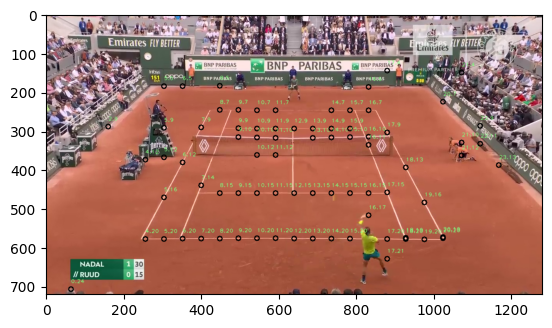

In [1151]:
VC.show_frame(frame_plot)

In [1152]:
id_x = 10
id_y = 12
lx1 = x_vlines[id_x] 
ly1 = y_hlines[id_y]
ly2 = ly1 + y_diff
lx2 = lx1 + 1

# Make the vertical slice
v_slice = frame[ly1:ly2,lx1:lx2]
#gray = cv2.cvtColor(v_slice, cv2.COLOR_RGB2GRAY)

In [1153]:
VC.show_frame(v_slice)

In [1154]:
is_line, idx_middle_line = vslice_is_line(v_slice, court_type)
print(is_line, idx_middle_line)

True 2


In [1155]:
# Get the median color of the slice
vsq = np.squeeze(v_slice)
vmedian = np.median(vsq, axis=0)
vmedian = vmedian[None, :]

# Median color should fit the court color
is_median_court = is_court_color(vmedian, court_type)
if not is_median_court:
    print(-1)
    #return False, -1

# Vertical and Horizontal Lags
pixel_diff = 1
rep = np.repeat(vmedian, pixel_diff, axis=0)
vshift_up_1 = np.vstack((vsq[pixel_diff:, :], rep))
vshift_down_1 = np.vstack((rep, vsq[:-pixel_diff, :]))

# Gradient
dx_vsq = vshift_up_1 - vsq
mask_grads = mask_tolerance(dx_vsq, (15,15,15), abs_val=True)  # np.array(np.abs(dx_vsq) > c.GRAD_TOL, dtype=np.int8)

# Collapse all channels into a 1D binary gradient array, considering 
# a 1 only if >=2 channels have a gradient color difference above threshold
mask_grad_lighter = mask_tolerance(dx_vsq, (30,30,30))
mask_grad_darker = mask_tolerance(dx_vsq, (-30,-30,-30), greater_than_tol=False)
bin_grad_light = np.array(np.sum(mask_grad_lighter, axis=1) > 1, dtype=np.int8)
bin_grad_dark = np.array(np.sum(mask_grad_darker, axis=1) > 1, dtype=np.int8)

if sum(bin_grad_light) and sum(bin_grad_dark):
    idx_turn_light = np.min(np.where(bin_grad_light)[0])
    idx_turn_dark = np.max(np.where(bin_grad_dark)[0])
    if idx_turn_dark < idx_turn_light:
        print(-2)


bin_grad = np.array(np.sum(mask_grads, axis=1) > 1, dtype=np.int8)
if np.sum(bin_grad) < 1:
    print(-3)

# Convert numbers in between
idx_1s = np.where(bin_grad)[0]
min_1_idx, max_1_idx = np.min(idx_1s), np.max(idx_1s)
diff_min_max_1s = max_1_idx - min_1_idx
is_line_width = diff_min_max_1s < c.GRAD_LINE_MAX_WIDTH

# Check that the middle index of the line mask corresponds to a white
if min_1_idx < max_1_idx:
    arr_sequence_ones = v_slice[min_1_idx:max_1_idx+1, 0, :]
    if arr_sequence_ones.shape[0] <= 1:
        arg_max_rgb = 0
    else:
        arg_max_rgb = np.argmax(np.linalg.norm(arr_sequence_ones, axis=1))
    max_rgb_idx = list(range(min_1_idx, max_1_idx + 1))[arg_max_rgb]
else:
    max_rgb_idx = max_1_idx
is_white_clean = is_near_color(c.D_GRAD_LINES[court_type]["LINE_CLEAN"], v_slice[max_rgb_idx])
is_white_dirty = is_near_color(c.D_GRAD_LINES[court_type]["LINE_DIRTY"], v_slice[max_rgb_idx], tol_ch1 = 15, tol_ch2 = 25)
is_white = is_white_clean or is_white_dirty
if not is_white:
    print(-4)

# Check that starting and ending colors are the court ones
is_valid_slice_color = True
if (bin_grad[0] == 0) and (bin_grad[-1] == 0):
    is_first_pixel_white_clean = is_near_color(c.D_GRAD_LINES[court_type]["LINE_CLEAN"], v_slice[0])
    is_first_pixel_white_dirty = is_near_color(c.D_GRAD_LINES[court_type]["LINE_DIRTY"], v_slice[0])
    is_last_pixel_white_clean = is_near_color(c.D_GRAD_LINES[court_type]["LINE_CLEAN"], v_slice[-1])
    is_last_pixel_white_dirty = is_near_color(c.D_GRAD_LINES[court_type]["LINE_DIRTY"], v_slice[-1])

    is_first_pixel_court_color = is_court_color(v_slice[0], court_type)
    is_last_pixel_court_color = is_court_color(v_slice[-1], court_type)
    is_first_any_white = (is_first_pixel_white_clean or is_first_pixel_white_dirty)
    is_last_any_white = (is_last_pixel_white_clean or is_last_pixel_white_dirty)
    is_edge_pixels_any_white = (is_first_any_white and ~is_last_any_white) or (~is_first_any_white and is_last_any_white)
    is_slice_court_color = is_first_pixel_court_color and is_last_pixel_court_color
    is_valid_slice_color = is_edge_pixels_any_white or is_slice_court_color

# Tell if it is a line or not
if is_median_court and is_line_width and is_white and is_valid_slice_color:
    print(True, max_rgb_idx)
else:
    print(-5)

True 2


In [1167]:
is_near_color(c.D_GRAD_LINES[court_type]["LINE_DIRTY"], v_slice[max_rgb_idx], tol_ch1 = 15, tol_ch2 = 25)

False

In [1160]:
v_slice[max_rgb_idx]

array([[182,  99,  79]], dtype=uint8)

In [1159]:
c.D_GRAD_LINES[court_type]["LINE_DIRTY"]

array([189, 130, 107])

In [1158]:
is_white_dirty

True

In [1142]:
dx_vsq = vshift_up_1 - vsq

In [1141]:
vshift_up_1 - vsq

array([[  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [ -2.,  -2.,  -2.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [ -1.,  -1.,  -1.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  3.,   3.,   3.],
       [  2.,   2.,   2.],
       [ -5.,  -5.,  -5.],
       [  5.,   5.,   5.],
       [ 22.,  22.,  22.],
       [ -5.,  -5.,  -5.],
       [-21., -21., -21.],
       [  0.,   0.,   0.],
       [  5.,   5.,   5.],
       [ -2.,  -2.,  -2.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0.,   2.],
       [ -1.,  -1.,  -1.],
       [  1.,  -1.,   2.],
       [  0.,   0.,   0.],
       [ -1.,   1.,  -4.]])

------

In [849]:
d_l = {}
for gs in d_f:
    f_gs = d_f[gs].copy()
    rgb_court, court_type = vc_rg.detect_court(f_gs)
    d_l[gs] = VC.get_line_mask(f_gs, court_type, tol=np.array([30,10,5]))

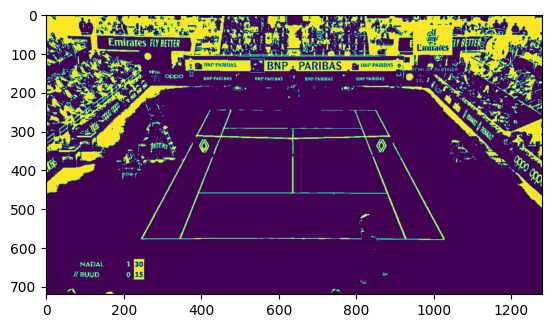

CPU times: user 283 ms, sys: 28.8 ms, total: 312 ms
Wall time: 170 ms


In [850]:
%%time
gray = d_l["rg"].copy()
gray_filt = _filter_pixels(gray)
VC.show_frame(gray)

##### Filter pixels by shifting image

In [817]:
dist_tau = 3
intensity_threshold = 40
def _filter_pixels(gray):
    """
    Filter pixels by using the court line structure
    """
    hshift_right = np.hstack((np.zeros((h, c1)), gray[:, :c2]))
    hshift_left = np.hstack((gray[:, c1:], np.zeros((h, c1))))

    vshift_up = np.vstack((gray[r1:, :], np.zeros((r1, w))))
    vshift_down = np.vstack((np.zeros((r1, w)), gray[:r2, :]))

    hmask = np.logical_and(gray - hshift_right > intensity_threshold, gray - hshift_left > intensity_threshold)
    vmask = np.logical_and(gray - vshift_up > intensity_threshold, gray - vshift_down > intensity_threshold)

    mask = np.logical_not(np.logical_or(hmask, vmask))
    t = gray.copy()
    t[mask] = 0
    return t

In [833]:
%%time
gray = d_l["rg"].copy()
gray_filt = _filter_pixels(gray)
VC.show_frame(gray)

CPU times: user 15.2 ms, sys: 6.18 ms, total: 21.4 ms
Wall time: 19.8 ms


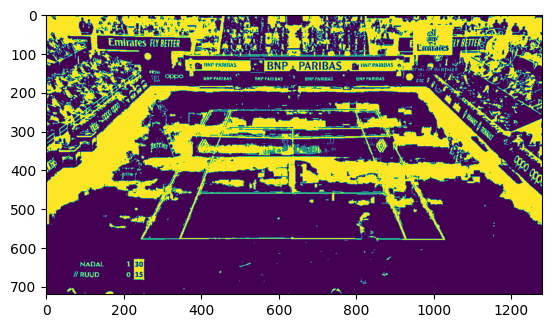

In [834]:
VC.show_frame(gray)

#### Detect Lines

In [819]:
%%time
minLineLength = 100
maxLineGap = 20

lines = cv2.HoughLinesP(gray, 1, np.pi / 180, 80, minLineLength=minLineLength, maxLineGap=maxLineGap)
lines = np.squeeze(lines)

CPU times: user 123 ms, sys: 2.01 ms, total: 125 ms
Wall time: 124 ms


In [812]:
def _classify_lines(lines):
        """
        Classify line to vertical and horizontal lines
        """
        horizontal = []
        vertical = []
        highest_vertical_y = np.inf
        lowest_vertical_y = 0
        for line in lines:
            x1, y1, x2, y2 = line
            dx = abs(x1 - x2)
            dy = abs(y1 - y2)
            if dx > 2 * dy:
                horizontal.append(line)
            else:
                vertical.append(line)
                highest_vertical_y = min(highest_vertical_y, y1, y2)
                lowest_vertical_y = max(lowest_vertical_y, y1, y2)

        # Filter horizontal lines using vertical lines lowest and highest point
        clean_horizontal = []
        h = lowest_vertical_y - highest_vertical_y
        lowest_vertical_y += h / 15
        highest_vertical_y -= h * 2 / 15
        for line in horizontal:
            x1, y1, x2, y2 = line
            if lowest_vertical_y > y1 > highest_vertical_y and lowest_vertical_y > y1 > highest_vertical_y:
                clean_horizontal.append(line)
        return clean_horizontal, vertical

In [820]:
%%time
# Classify the lines using their slope
raw_horizontal, raw_vertical = _classify_lines(lines)

CPU times: user 4.4 ms, sys: 95 µs, total: 4.49 ms
Wall time: 4.48 ms


#### Merge lines that belong to the same line on the frame

In [755]:
from sympy import Line

In [779]:
def line_intersection(line1, line2):
    """
    Find 2 lines intersection point
    """
    l1 = Line(line1[0], line1[1])
    l2 = Line(line2[0], line2[1])

    intersection = l1.intersection(l2)
    return intersection[0].coordinates

In [780]:
def _merge_lines(horizontal_lines, vertical_lines, height, width):
    """
    Merge lines that belongs to the same frame`s lines
    """

    # Merge horizontal lines
    horizontal_lines = sorted(horizontal_lines, key=lambda item: item[0])
    mask = [True] * len(horizontal_lines)
    new_horizontal_lines = []
    for i, line in enumerate(horizontal_lines):
        if mask[i]:
            for j, s_line in enumerate(horizontal_lines[i + 1:]):
                if mask[i + j + 1]:
                    x1, y1, x2, y2 = line
                    x3, y3, x4, y4 = s_line
                    dy = abs(y3 - y2)
                    if dy < 10:
                        points = sorted([(x1, y1), (x2, y2), (x3, y3), (x4, y4)], key=lambda x: x[0])
                        line = np.array([*points[0], *points[-1]])
                        mask[i + j + 1] = False
            new_horizontal_lines.append(line)

    # Merge vertical lines
    vertical_lines = sorted(vertical_lines, key=lambda item: item[1])
    xl, yl, xr, yr = (0, height * 6 / 7, width, height * 6 / 7)
    mask = [True] * len(vertical_lines)
    new_vertical_lines = []
    for i, line in enumerate(vertical_lines):
        if mask[i]:
            for j, s_line in enumerate(vertical_lines[i + 1:]):
                if mask[i + j + 1]:
                    x1, y1, x2, y2 = line
                    x3, y3, x4, y4 = s_line
                    xi, yi = line_intersection(((x1, y1), (x2, y2)), ((xl, yl), (xr, yr)))
                    xj, yj = line_intersection(((x3, y3), (x4, y4)), ((xl, yl), (xr, yr)))

                    dx = abs(xi - xj)
                    if dx < 10:
                        points = sorted([(x1, y1), (x2, y2), (x3, y3), (x4, y4)], key=lambda x: x[1])
                        line = np.array([*points[0], *points[-1]])
                        mask[i + j + 1] = False

            new_vertical_lines.append(line)
    return new_horizontal_lines, new_vertical_lines

In [783]:
%%time
# Merge lines that belong to the same line on frame
horizontal, vertical = _merge_lines(horizontal, vertical, height=h, width=w)

CPU times: user 21.3 s, sys: 29.4 ms, total: 21.3 s
Wall time: 21.3 s


In [821]:
def display_lines_on_frame(frame, horizontal=(), vertical=()):
    """
    Display lines on frame for horizontal and vertical lines
    """

    '''cv2.line(frame, (int(len(frame[0]) * 4 / 7), 0), (int(len(frame[0]) * 4 / 7), 719), (255, 255, 0), 2)
    cv2.line(frame, (int(len(frame[0]) * 3 / 7), 0), (int(len(frame[0]) * 3 / 7), 719), (255, 255, 0), 2)'''
    radius_circle = 20
    for line in horizontal:
        x1, y1, x2, y2 = line
        cv2.line(frame, (x1, y1), (x2, y2), (0, 255, 0), radius_circle)
        cv2.circle(frame, (x1, y1), 1, (255, 0, 0), radius_circle)
        cv2.circle(frame, (x2, y2), 1, (255, 0, 0), radius_circle)

    for line in vertical:
        x1, y1, x2, y2 = line
        
        cv2.line(frame, (x1, y1), (x2, y2), (0, 0, 255), radius_circle)
        cv2.circle(frame, (x1, y1), 1, (255, 0, 0), radius_circle)
        cv2.circle(frame, (x2, y2), 1, (255, 0, 0), radius_circle)

    plt.imshow(frame)
    return True

In [823]:
edges = cv2.Canny(gray_filt, 100, 250)

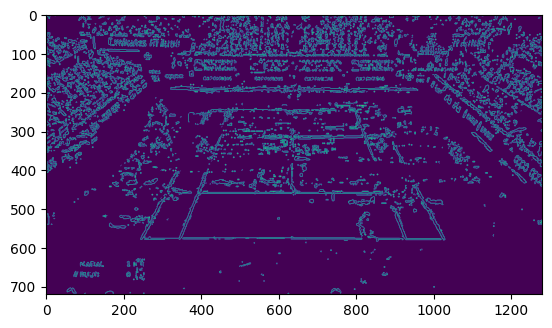

In [826]:
VC.show_frame(edges)

True

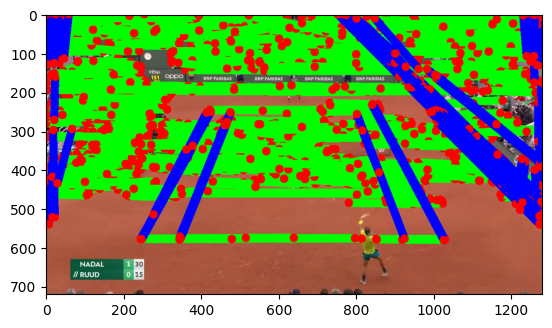

In [822]:
frame = d_f["rg"].copy()
display_lines_on_frame(frame, raw_horizontal, raw_vertical)

#### Filter pixels by shifting image

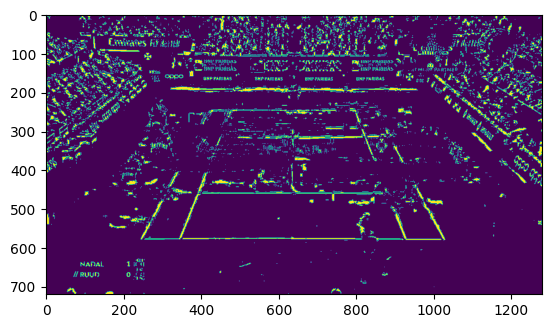

In [828]:
VC.show_frame(gray_filt)

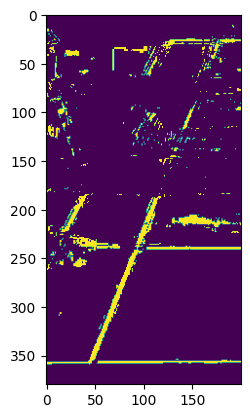

In [831]:
VC.show_frame(gray_filt[220:600,300:500])

In [623]:
t = gray.copy()

In [625]:
#for i in range(dist_tau, len(gray) - dist_tau):

In [673]:
row = gray[0, :]

In [658]:
h, w = gray.shape

In [674]:
len(row)


1280

In [677]:
c1 = dist_tau
c2 = w - c1
r1 = dist_tau
r2 = h - r1

In [731]:
hshift_right = np.hstack((np.zeros((h, c1)), gray[:, :c2]))
hshift_left = np.hstack((gray[:, c1:], np.zeros((h, c1))))

vshift_up = np.vstack((gray[r1:, :], np.zeros((r1, w))))
vshift_down = np.vstack((np.zeros((r1, w)), gray[:r2, :]))

hmask = np.logical_and(gray - hshift_right > intensity_threshold, gray - hshift_left > intensity_threshold)
vmask = np.logical_and(gray - vshift_up > intensity_threshold, gray - vshift_down > intensity_threshold)

mask = np.logical_not(np.logical_or(hmask, vmask))
t = gray.copy()
t[mask] = 0

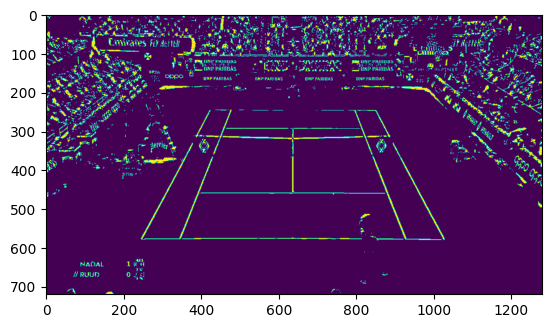

In [732]:
VC.show_frame(t)

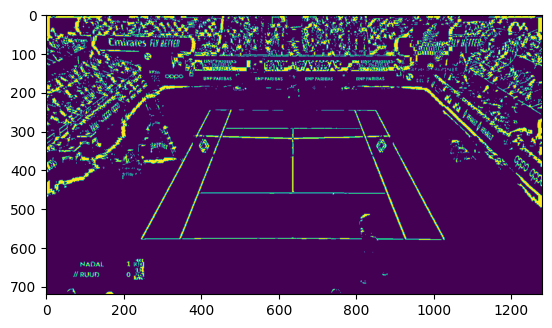

In [733]:
VC.show_frame(t2)

In [691]:
t2 = _filter_pixels(gray)

In [656]:
gray_mask = gray.copy()

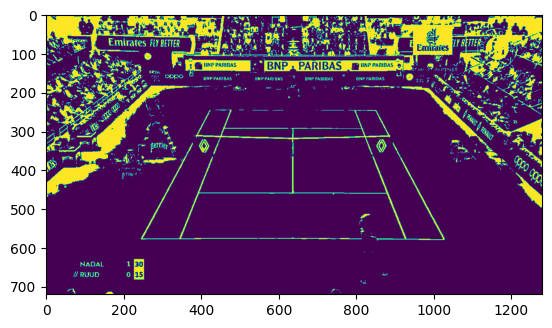

In [596]:
gray = d_l["rg"].copy()
VC.show_frame(gray)

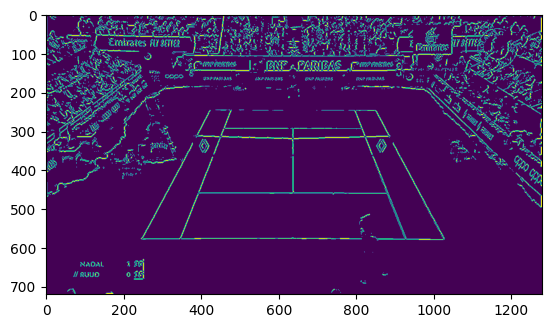

In [601]:
VC.show_frame(gray)

---------------

---------------

---------------

---------------

---------------

---------------

In [586]:
f_harris = np.float32(f_test)
dst = cv2.cornerHarris(f_harris, blockSize=5, ksize=21, k=0.04)
#result is dilated for marking the corners, not important
dst = cv2.dilate(dst, None)
# Threshold for an optimal value, it may vary depending on the image.
th_corner = 0.01*dst.max()
#f_harris[dst>th_corner]=[0,0,255]

In [587]:
th_corner = 0.01*dst.max()
mask_corners = dst>th_corner

In [588]:
np.where(mask_corners)[0].shape

(164009,)

In [565]:
dst.shape

(720, 1280)

In [564]:
dst.max()

0.26578125

In [563]:
dst

array([[-0.01, -0.01, -0.01, ...,  0.  ,  0.  ,  0.  ],
       [-0.01, -0.01, -0.01, ...,  0.  ,  0.  ,  0.  ],
       [-0.01, -0.01, -0.01, ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ]], dtype=float32)

In [540]:
lw = 10
pad = lw//2
stride_h = 600
c2d = torch.nn.Conv2d(1,1,(lw, stride_h), stride=(lw,stride_h), padding=(pad, 0))
c2d.weight = torch.nn.Parameter(torch.ones_like(c2d.weight))
t_gs = torch.tensor(f_test, dtype=torch.float)
t_gs = torch.unsqueeze(t_gs, dim=0)

In [543]:
# Convolve on 2D
c2d_o = c2d(t_gs)
c2d_o = c2d_o.squeeze()
c2d_o, _ = torch.min(c2d_o, dim=1)

In [544]:
torch.argsort(c2d_o, descending=True)

tensor([ 2,  4,  5,  3,  1,  6, 14, 13,  7,  8, 12, 10,  9, 11, 19, 15, 32, 17,
        16, 29, 25, 58, 31, 27, 46, 30, 26,  0, 28, 24, 23, 20, 22, 35, 33, 21,
        34, 36, 37, 38, 18, 39, 40, 42, 45, 43, 41, 44, 57, 47, 55, 52, 56, 53,
        54, 51, 48, 50, 49, 67, 71, 72, 61, 63, 64, 65, 66, 60, 68, 69, 70, 59,
        62])

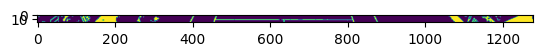

In [555]:
argmax = 29
VC.show_frame(f_test[argmax*lw-lw:argmax*lw+lw,:])

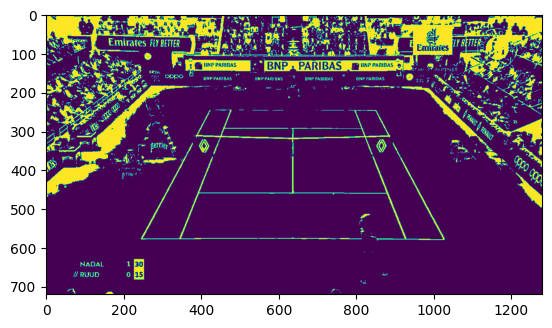

In [554]:
VC.show_frame(f_test)

tensor([64, 33, 26, 32, 50,  1, 14,  5, 40, 42, 31, 41, 63, 62, 18, 61, 58, 60,
        59, 57, 56, 55, 53, 51, 54, 52, 19, 46, 48, 49, 47, 45, 43, 38, 44, 37,
        36, 15,  4, 39, 35, 30, 28, 29, 27, 34,  0,  6, 16, 17, 13, 20,  2, 10,
        12, 11, 21, 22, 23,  7,  8,  9, 24,  3, 25, 65, 66, 67, 68, 69, 70, 71,
        72])

In [509]:
xxx[torch.argsort(xxx, descending=True)]

tensor([ 2.4286e+04,  7.1643e+03,  7.0914e+03,  6.6543e+03,  6.6361e+03,
         6.0957e+03,  5.7678e+03,  5.5675e+03,  5.1850e+03,  4.5596e+03,
         4.0436e+03,  3.2846e+03,  2.6714e+03,  2.4711e+03,  2.3132e+03,
         2.2464e+03,  2.1371e+03,  2.0825e+03,  1.8821e+03,  1.8761e+03,
         1.8275e+03,  1.7850e+03,  1.7668e+03,  1.6878e+03,  1.5725e+03,
         1.5603e+03,  1.5603e+03,  1.5057e+03,  1.3843e+03,  1.3661e+03,
         1.3539e+03,  1.3418e+03,  1.3236e+03,  1.3175e+03,  1.2993e+03,
         1.2871e+03,  1.2811e+03,  1.2811e+03,  1.2568e+03,  1.2507e+03,
         1.2446e+03,  1.2446e+03,  1.2446e+03,  1.2082e+03,  1.1839e+03,
         1.1778e+03,  1.1778e+03,  1.1596e+03,  1.1536e+03,  1.1475e+03,
         1.0321e+03,  9.1070e+02,  9.1070e+02,  8.9248e+02,  8.0141e+02,
         7.8320e+02,  6.0105e+02,  5.5855e+02,  4.8570e+02,  3.2177e+02,
         2.1855e+02,  2.0034e+02,  1.8820e+02,  5.4626e+01,  3.6412e+01,
         2.4269e+01,  6.0549e+00, -1.6528e-02, -1.6

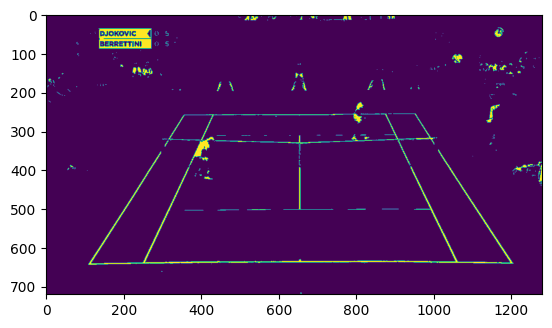

In [487]:
VC.show_frame(f_test)

## 2.3 Main colors segmentation

In [105]:
from collections import Counter
import pandas as pd
import seaborn as sns

In [200]:
def rgb2hex(r,g,b):
    return "#{:02x}{:02x}{:02x}".format(r,g,b)

In [343]:
f_court = d_f["ao"]

In [344]:
# ksize
ksize = (10, 10)
  
# Using cv2.blur() method 
f_court = cv2.blur(f_court, ksize) 

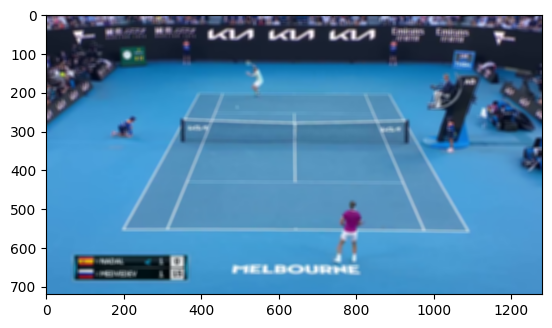

In [345]:
VC.show_frame(f_court)

In [346]:
color_bins = np.arange(0, 256, 5)
ind_r = np.digitize(f_court[:,:,0], color_bins)
ind_g = np.digitize(f_court[:,:,1], color_bins)
ind_b = np.digitize(f_court[:,:,2], color_bins)

In [347]:
ind_rgb = np.vstack((ind_r.ravel(),ind_g.ravel(),ind_b.ravel()))

In [348]:
df_bins_rgb = pd.DataFrame(ind_rgb).T
df_bins_rgb.columns = ["R", "G", "B"]
df_hist_rgb_bins = df_bins_rgb.groupby(["R","G","B"]).size().reset_index(name="freq").sort_values("freq", ascending=False)

In [349]:
l_rgb_most = []
top_colors = 10
for rgb in df_hist_rgb_bins.head(top_colors).values[:top_colors,:3]:
    rgb_tup = ()
    for chan in range(3):
        rgb_tup += (color_bins[rgb[chan]],)
    l_rgb_most.append(rgb_tup)
l_rgb_hex = [rgb2hex(*xx) for xx in l_rgb_most]

In [350]:
l_rgb_most

[(90, 150, 195),
 (90, 155, 195),
 (25, 35, 50),
 (75, 160, 215),
 (90, 150, 190),
 (70, 160, 220),
 (80, 165, 220),
 (70, 160, 215),
 (65, 150, 205),
 (85, 150, 190)]

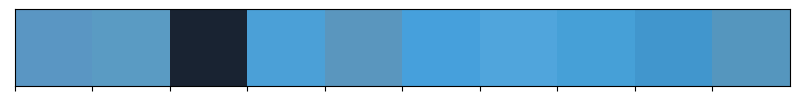

In [351]:
sns.palplot(l_rgb_hex)

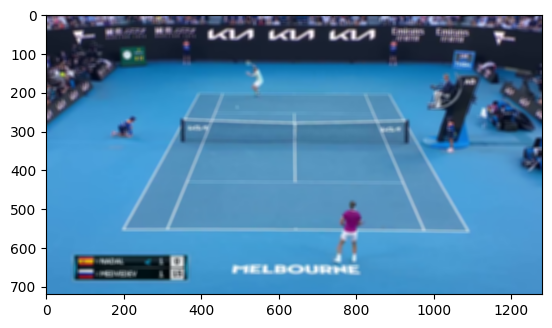

In [352]:
VC.show_frame(f_court)

## 2.1 Trapezoidal Approach

In [892]:
class CourtTrapezoid:
    def __init__(self, vc):
        # X: first coordinate, corresponds to width
        # initialize pA to be in the bottom left corner (max height)
        self.vc = vc
        self.pA = (0, self.vc.h)
        self.add = lambda x,y: (int(x[0]+y[0]), int(x[1]+y[1]))
        self.flip = lambda tup: (tup[1], tup[0])
        self.white = (255, 255, 255)
        
    def generate_trapezoid_points(self,a,b,f,sc=1):
        a = int(a*sc)
        b = int(b*sc)
        f = int(f*sc)
        e = (a-b)//2
        pA = self.pA
        pB = self.add(pA, (e,-f))
        pC = self.add(pB, (b,0))
        pD = self.add(pA, (a,0))
        return np.array([pA, pB, pC, pD])
    
    def create_trapezoid(self, a, b, f, sc=1, stride=(0,0), thickness=15, img_input=None):
        pts = self.generate_trapezoid_points(a,b,f,sc)
        strided_pts = np.array([pts]) + np.array([stride])
        
        # Take the two images 
        img_trapezoid = np.zeros((self.vc.h, self.vc.w), np.uint8)
        if img_input is not None:
            img = copy.copy(img_input)
        
        # Fill the trapezoid empty image
        cv2.polylines(img_trapezoid, strided_pts, isClosed=True, color=self.white, thickness=thickness)
        
        # Fill the input image if given
        if img_input is not None:
            cv2.polylines(img, strided_pts, isClosed=True, color=self.white, thickness=thickness)
        
        #self.vc.show_frame(img)
        return img_trapezoid, img, img_input, strided_pts
    
    @staticmethod
    def compute_gain(image_trapezoid, image_input, mask=None):
        if mask is not None:
            i1 = image_trapezoid[mask[0,0]:mask[0,1], mask[1,0]:mask[1,1]]
            i2 = image_input[mask[0,0]:mask[0,1], mask[1,0]:mask[1,1]]
        else:
            i1 = image_trapezoid
            i2 = image_input
        i3 = i1 * i2
        iv = np.sum(i3, axis=0)
        ih = np.sum(i3, axis=1)
        iv[iv>0] = 1
        ih[ih>0] = 1
        gain_v = sum(iv) / iv.shape[0]
        gain_h = sum(ih) / ih.shape[0]
        gain = np.mean([gain_v, gain_h])
        return gain
    
    

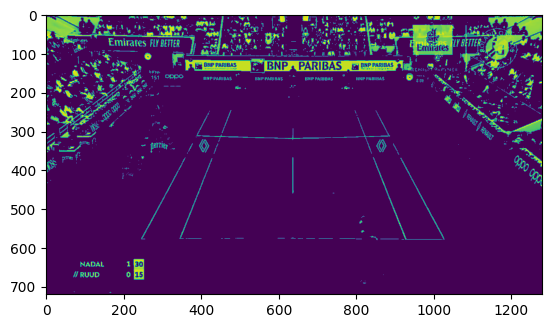

In [893]:
vc_ao.show_frame(img_video)

In [895]:
# Fixed
court_trapezoid = CourtTrapezoid(vc_wb)
h, w = vc_us.h, vc_us.w

y_range_stride = [0, h//2]

# First Evaluation Mask
y_range_mpA = [0, h]
x_range_mpA = [0,w//2]
mpA = np.array([y_range_mpA, x_range_mpA])
img_video = d_neg["rg"]

# ------------------------------------- #

# ------------------------------------- #
#     Optimize first corner
# ------------------------------------- #

# ------------------------------------- #
# Fixed
thickness = 20
scale = 1
a = int(w)
b = int(w)
f = int(h)

# ************************* #
# Generate mesh of strides
# ************************* #
# Start from bottom left in X and Y
x = np.arange(x_range_mpA[0], x_range_mpA[1], thickness)
y = np.arange(y_range_stride[0], y_range_stride[1], thickness)

# Meshgrid based on the thickness of the first attempt line
xv, yv = np.meshgrid(x, y)
xy_mesh = np.array(np.c_[xv.ravel(), yv.ravel()], dtype=int)

# ************************* #
# Generate mesh of trapezoid params
# ************************* #
# Create mesh of trapezoid params
step_size = 0.2
frac_a = np.arange(0.6, 0.9, step_size)
frac_b = np.arange(0.2, 0.5, step_size)
frac_f = np.arange(0.4, 0.6, step_size)
av, bv, fv = np.meshgrid(frac_a, frac_b, frac_f)
abf_mesh = np.array(np.c_[av.ravel(), bv.ravel(), fv.ravel()], dtype=float)

In [896]:
%time
gain_opt = 0
it_stride_optim = 0
img_trapezoid_opt, img_final_opt, img_input_opt, strided_pts_opt = None, None, None, None
for it_stride, (xx, yy) in tqdm.tqdm(enumerate(xy_mesh)):
    
    # Create trapezoid
    stride_pts = (xx,-yy)
    
    # Iterate on the mesh of trapezoid params
    for it_params, (frac_aa, frac_bb, frac_ff) in enumerate(abf_mesh):
        
        it_a = a * frac_aa
        it_b = b * frac_bb
        it_f = b * frac_ff

        # Calculate trapezoid
        img_trapezoid, img_final, img_input, strided_pts = court_trapezoid.create_trapezoid(it_a,it_b,it_f, thickness=thickness, stride=stride_pts, img_input=img_video)

        # Evaluation
        gain = court_trapezoid.compute_gain(img_trapezoid, img_input, mpA)
        #img_trapezoid_pA = img_trapezoid[mpA[0,0]:mpA[0,1], mpA[1,0]:mpA[1,1]]
        #img_input_pA = img_input[mpA[0,0]:mpA[0,1], mpA[1,0]:mpA[1,1]]
        #gain = np.sum(img_trapezoid_pA * img_input_pA)
        if gain > gain_opt:
            it_stride_optim = it_stride
            it_params_optim = it_params
            it_a_optim = it_a
            it_b_optim = it_b
            it_f_optim = it_f
            gain_opt = gain
            img_trapezoid_opt = img_trapezoid
            img_final_opt = img_final
            img_input_opt = img_input
            strided_pts_opt = strided_pts


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


576it [00:02, 260.53it/s]


In [900]:
np.mean(strided_pts_opt, axis=1)

array([[424., 304.]])

In [902]:
ixx = img_final_opt.copy()
cv2.circle(ixx, [424, 304], 5, (255, 255, 255), 3)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

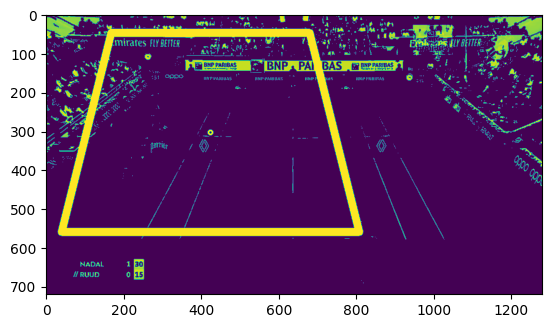

In [903]:
vc_us.show_frame(ixx)

In [708]:
# Create trapezoid
xx, yy = xy_mesh[40]
stride_pts = (xx,-yy)
img_trapezoid, img_final, img_input, strided_pts = court_trapezoid.create_trapezoid(a,b,f,sc=scale, thickness=thickness, stride=stride_pts, img_input=img_video)

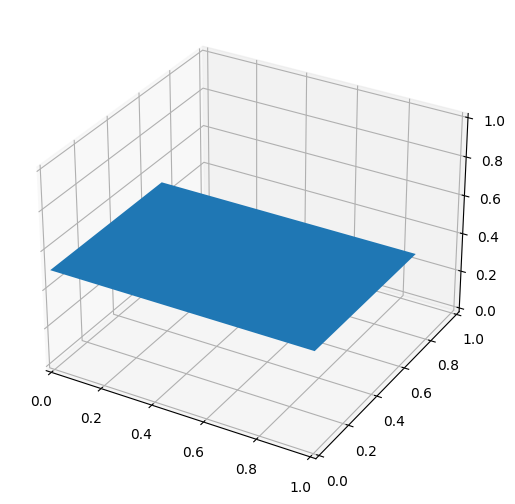

In [446]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)

rect = np.array([[[ 0,  0],
        [ 0,  .7],
        [ 1,  .7],
        [1,  0]]])

fig.add_axes(ax)
x = list(rect[0][:,0])
y = list(rect[0][:,1])
z = [.5,.5,.5,.5]
verts = [list(zip(x,y,z))]
ax.add_collection3d(Poly3DCollection(verts))
plt.show()

In [392]:
np.sum(img_trapezoid * img_input)

81836

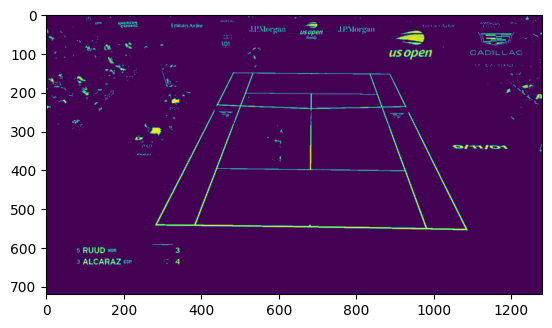

In [357]:
vc_us.show_frame(img_input)

In [263]:
def get_3d_rotation_matrix(width, height, theta, phi, gamma, dx, dy, dz):
    w, h = width, height
    d = np.sqrt(w ** 2 + h ** 2)
    focal = f = d / (2 * np.sin(gamma) if np.sin(gamma) != 0 else 1)
    dz = focal

    # Projection 2D -> 3D matrix
    A1 = np.array([[1, 0, -w / 2],
                   [0, 1, -h / 2],
                   [0, 0, 1],
                   [0, 0, 1]])

    # Rotation matrices around the X, Y, and Z axis
    RX = np.array([[1, 0, 0, 0],
                   [0, np.cos(theta), -np.sin(theta), 0],
                   [0, np.sin(theta), np.cos(theta), 0],
                   [0, 0, 0, 1]])

    RY = np.array([[np.cos(phi), 0, -np.sin(phi), 0],
                   [0, 1, 0, 0],
                   [np.sin(phi), 0, np.cos(phi), 0],
                   [0, 0, 0, 1]])

    RZ = np.array([[np.cos(gamma), -np.sin(gamma), 0, 0],
                   [np.sin(gamma), np.cos(gamma), 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])

    # Composed rotation matrix with (RX, RY, RZ)
    R = np.dot(np.dot(RX, RY), RZ)

    # Translation matrix
    T = np.array([[1, 0, 0, dx],
                  [0, 1, 0, dy],
                  [0, 0, 1, dz],
                  [0, 0, 0, 1]])

    # Projection 3D -> 2D matrix
    A2 = np.array([[f, 0, w / 2, 0],
                   [0, f, h / 2, 0],
                   [0, 0, 1, 0]])

    # Final transformation matrix
    return np.dot(A2, np.dot(T, np.dot(R, A1)))


def get_image_3d_rotated(image, theta, phi, gamma, dx, dy, dz):
    height, width, _ = image.shape
    rtheta, rphi, rgamma = np.deg2rad(theta), np.deg2rad(phi), np.deg2rad(gamma)
    mat = get_3d_rotation_matrix(width, height, rtheta, rphi, rgamma, dx, dy, dz)

    return cv2.warpPerspective(image.copy(), mat, (width, height))


if __name__ == '__main__':
    image = cv2.imread('1.jpg')
    rotated_img = get_image_3d_rotated(image, 15, 16, 17, 0, 0, 0)

Docstring:
rotate(src, rotateCode[, dst]) -> dst
.   @brief Rotates a 2D array in multiples of 90 degrees.
.   The function cv::rotate rotates the array in one of three different ways:
.   *   Rotate by 90 degrees clockwise (rotateCode = ROTATE_90_CLOCKWISE).
.   *   Rotate by 180 degrees clockwise (rotateCode = ROTATE_180).
.   *   Rotate by 270 degrees clockwise (rotateCode = ROTATE_90_COUNTERCLOCKWISE).
.   @param src input array.
.   @param dst output array of the same type as src.  The size is the same with ROTATE_180,
.   and the rows and cols are switched for ROTATE_90_CLOCKWISE and ROTATE_90_COUNTERCLOCKWISE.
.   @param rotateCode an enum to specify how to rotate the array; see the enum #RotateFlags
.   @sa transpose , repeat , completeSymm, flip, RotateFlags
Type:      builtin_function_or_method


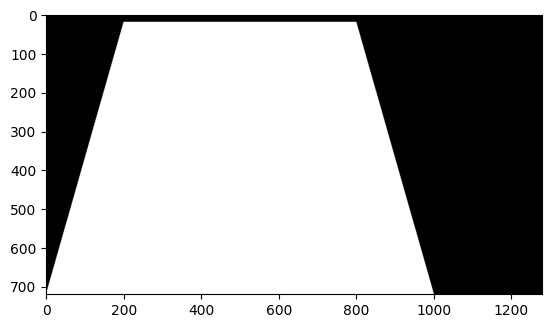

In [396]:
import cv2 as cv
import numpy as np

RED = (255, 255, 255)
pts = [pA, pB, pC, pD]
#pts = [flip(pp) for pp in pts]
#pts = [(0,720), (70, 740), (-70, 800), (100, 720)]

img = np.zeros((VC.h, VC.w, 3), np.uint8)
cv.fillPoly(img, np.array([pts]), RED)
VC.show_frame(img)

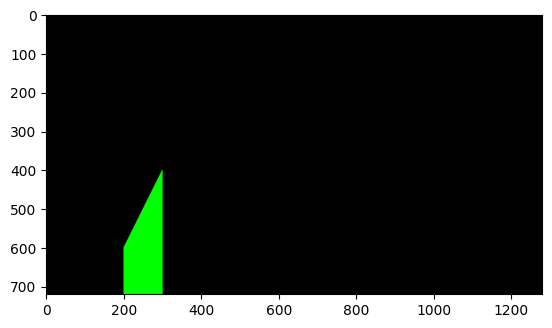

In [200]:
img = np.zeros((VC.h, VC.w, 3), np.uint8)
pts = [(200,600), (300, 400), (300, 800), (200, 800)]
cv.fillPoly(img, np.array([pts]), RED)
VC.show_frame(img)

In [162]:
img.shape

(720, 1280, 3)